In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from textblob import TextBlob
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import preprocess_text
import warnings
warnings.filterwarnings('ignore')

In [3]:
twitts_train = pd.read_csv("../data/twitter_training.csv")
twitts_valid = pd.read_csv("../data/twitter_validation.csv")

In [4]:
column_name=['tweetID','entity','sentiment','tweet_content']
twitts_train.columns=column_name
twitts_valid.columns=column_name

In [5]:
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())


Number of duplicate tweets in training set: 2700
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 686
Number of nan values in validation set: 0


In [6]:
# clean the duplicated tweets
twitts_train = twitts_train.drop_duplicates(subset=['tweet_content'])
twitts_valid = twitts_valid.drop_duplicates(subset=['tweet_content'])

# clean the empty tweets
twitts_train = twitts_train.dropna(subset=['tweet_content'])
twitts_valid = twitts_valid.dropna(subset=['tweet_content'])

# lower case the sentiment labels
twitts_train['sentiment'] = twitts_train['sentiment'].str.lower()
twitts_valid['sentiment'] = twitts_valid['sentiment'].str.lower()

# Remove the irrelevant sentiment label
twitts_train = twitts_train[twitts_train['sentiment'].isin(['positive', 'negative', 'neutral'])]
twitts_valid = twitts_valid[twitts_valid['sentiment'].isin(['positive', 'negative', 'neutral'])]

# Reset index after cleaning
twitts_train.reset_index(drop=True, inplace=True)
twitts_valid.reset_index(drop=True, inplace=True)

print("Number of tweets in training set after cleaning:", len(twitts_train))
print("Number of tweets in validation set after cleaning:", len(twitts_valid))

Number of tweets in training set after cleaning: 57274
Number of tweets in validation set after cleaning: 827


In [7]:
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())


Number of duplicate tweets in training set: 0
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 0
Number of nan values in validation set: 0


In [8]:
twitts_train['tweet_content'] = twitts_train['tweet_content'].apply(preprocess_text)
twitts_valid['tweet_content'] = twitts_valid['tweet_content'].apply(preprocess_text)

In [9]:
def sentiment_analysis(text):
    if pd.isna(text):
        return 0
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [10]:
print("Aplicando análise de sentimentos nos dados de treino...")
sentiment_results_train = twitts_train['tweet_content'].apply(sentiment_analysis)
twitts_train['polarity'] = [result[0] for result in sentiment_results_train]
twitts_train['subjectivity'] = [result[1] for result in sentiment_results_train]

print("Aplicando análise de sentimentos nos dados de validação...")
sentiment_results_valid = twitts_valid['tweet_content'].apply(sentiment_analysis)
twitts_valid['polarity'] = [result[0] for result in sentiment_results_valid]
twitts_valid['subjectivity'] = [result[1] for result in sentiment_results_valid]


Aplicando análise de sentimentos nos dados de treino...
Aplicando análise de sentimentos nos dados de validação...


In [11]:
def classify_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

twitts_train['predicted_sentiment'] = twitts_train['polarity'].apply(classify_sentiment)
twitts_valid['predicted_sentiment'] = twitts_valid['polarity'].apply(classify_sentiment)


In [12]:
print("Polaridade - Estatísticas descritivas:")
print(f"Treino - Média: {twitts_train['polarity'].mean():.3f}, "
      f"Desvio: {twitts_train['polarity'].std():.3f}")
print(f"Validação - Média: {twitts_valid['polarity'].mean():.3f}, "
      f"Desvio: {twitts_valid['polarity'].std():.3f}")
print()

print("Subjetividade - Estatísticas descritivas:")
print(f"Treino - Média: {twitts_train['subjectivity'].mean():.3f}, "
      f"Desvio: {twitts_train['subjectivity'].std():.3f}")
print(f"Validação - Média: {twitts_valid['subjectivity'].mean():.3f}, "
      f"Desvio: {twitts_valid['subjectivity'].std():.3f}")


Polaridade - Estatísticas descritivas:
Treino - Média: 0.067, Desvio: 0.342
Validação - Média: 0.056, Desvio: 0.354

Subjetividade - Estatísticas descritivas:
Treino - Média: 0.452, Desvio: 0.307
Validação - Média: 0.463, Desvio: 0.303


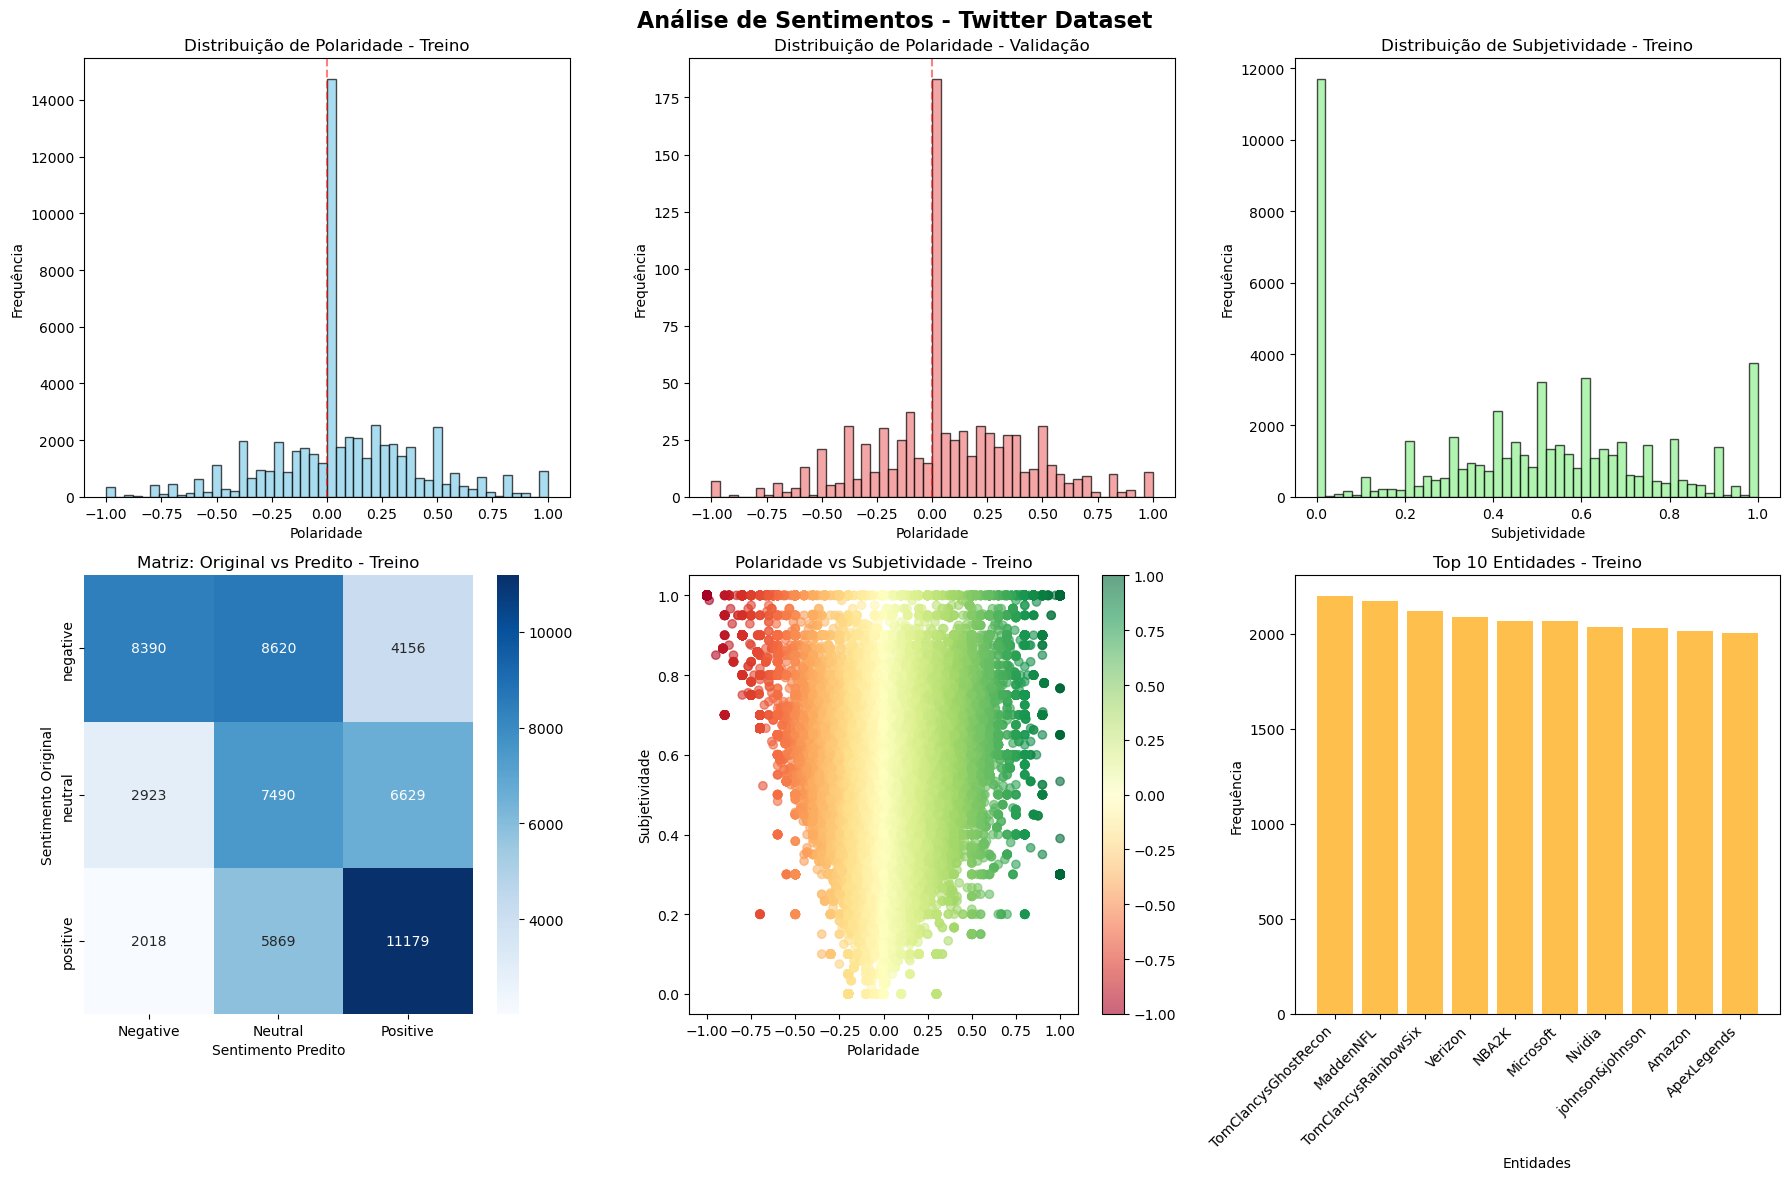

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análise de Sentimentos - Twitter Dataset', fontsize=16, fontweight='bold')

# 1. Distribuição de polaridade (treino)
axes[0, 0].hist(twitts_train['polarity'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição de Polaridade - Treino')
axes[0, 0].set_xlabel('Polaridade')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# 2. Distribuição de polaridade (validação)
axes[0, 1].hist(twitts_valid['polarity'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribuição de Polaridade - Validação')
axes[0, 1].set_xlabel('Polaridade')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# 3. Distribuição de subjetividade (treino)
axes[0, 2].hist(twitts_train['subjectivity'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Distribuição de Subjetividade - Treino')
axes[0, 2].set_xlabel('Subjetividade')
axes[0, 2].set_ylabel('Frequência')

# 4. Comparação de sentimentos originais vs preditos (treino)
sentiment_comparison = pd.crosstab(twitts_train['sentiment'], 
                                  twitts_train['predicted_sentiment'])
sns.heatmap(sentiment_comparison, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Matriz: Original vs Predito - Treino')
axes[1, 0].set_xlabel('Sentimento Predito')
axes[1, 0].set_ylabel('Sentimento Original')

# 5. Scatter plot: Polaridade vs Subjetividade
scatter = axes[1, 1].scatter(twitts_train['polarity'], twitts_train['subjectivity'], 
                           alpha=0.6, c=twitts_train['polarity'], cmap='RdYlGn')
axes[1, 1].set_title('Polaridade vs Subjetividade - Treino')
axes[1, 1].set_xlabel('Polaridade')
axes[1, 1].set_ylabel('Subjetividade')
plt.colorbar(scatter, ax=axes[1, 1])

# 6. Distribuição por entidade
entity_counts = twitts_train['entity'].value_counts().head(10)
axes[1, 2].bar(range(len(entity_counts)), entity_counts.values, color='orange', alpha=0.7)
axes[1, 2].set_title('Top 10 Entidades - Treino')
axes[1, 2].set_xlabel('Entidades')
axes[1, 2].set_ylabel('Frequência')
axes[1, 2].set_xticks(range(len(entity_counts)))
axes[1, 2].set_xticklabels(entity_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [14]:
def map_original_sentiment(sentiment):
    """Mapear sentimentos originais para formato padronizado"""
    sentiment = str(sentiment).lower()
    if 'positive' in sentiment:
        return 'Positive'
    elif 'negative' in sentiment:
        return 'Negative'
    else:
        return 'Neutral'

# Tentar mapear sentimentos originais
twitts_train['original_mapped'] = twitts_train['sentiment'].apply(map_original_sentiment)
twitts_valid['original_mapped'] = twitts_valid['sentiment'].apply(map_original_sentiment)



In [15]:

print("\nRelatório de classificação (Treino):")
print(classification_report(twitts_train['original_mapped'], 
                            twitts_train['predicted_sentiment']))


Relatório de classificação (Treino):
              precision    recall  f1-score   support

    Negative       0.63      0.40      0.49     21166
     Neutral       0.34      0.44      0.38     17042
    Positive       0.51      0.59      0.54     19066

    accuracy                           0.47     57274
   macro avg       0.49      0.47      0.47     57274
weighted avg       0.50      0.47      0.48     57274



In [16]:

print("\nRelatório de classificação (Validação):")
print(classification_report(twitts_valid['original_mapped'], 
                            twitts_valid['predicted_sentiment']))



Relatório de classificação (Validação):
              precision    recall  f1-score   support

    Negative       0.53      0.44      0.48       266
     Neutral       0.39      0.39      0.39       285
    Positive       0.53      0.61      0.57       276

    accuracy                           0.48       827
   macro avg       0.48      0.48      0.48       827
weighted avg       0.48      0.48      0.48       827



In [17]:
most_positive = twitts_train.nlargest(5, 'polarity')[['tweet_content', 'polarity', 'predicted_sentiment']]
print("TOP 5 TWEETS MAIS POSITIVOS:")
for idx, row in most_positive.iterrows():
    print(f"Polaridade: {row['polarity']:.3f} | Sentimento: {row['predicted_sentiment']}")
    print(f"Tweet: {row['tweet_content'][:100]}...")
    print("-" * 80)

TOP 5 TWEETS MAIS POSITIVOS:
Polaridade: 1.000 | Sentimento: Positive
Tweet: Platinum is the best loot...
--------------------------------------------------------------------------------
Polaridade: 1.000 | Sentimento: Positive
Tweet: Platinum is the best booty Borderlands...
--------------------------------------------------------------------------------
Polaridade: 1.000 | Sentimento: Positive
Tweet: Platinum is the best lot Borderlands...
--------------------------------------------------------------------------------
Polaridade: 1.000 | Sentimento: Positive
Tweet: Platinum has the best loot...
--------------------------------------------------------------------------------
Polaridade: 1.000 | Sentimento: Positive
Tweet: Platinum Rock is named the best loot...
--------------------------------------------------------------------------------


In [18]:
# Tweets mais negativos
most_negative = twitts_train.nsmallest(5, 'polarity')[['tweet_content', 'polarity', 'predicted_sentiment']]
print("\nTOP 5 TWEETS MAIS NEGATIVOS:")
for idx, row in most_negative.iterrows():
    print(f"Polaridade: {row['polarity']:.3f} | Sentimento: {row['predicted_sentiment']}")
    print(f"Tweet: {row['tweet_content'][:100]}...")
    print("-" * 80)


TOP 5 TWEETS MAIS NEGATIVOS:
Polaridade: -1.000 | Sentimento: Negative
Tweet: What terrible bitch...
--------------------------------------------------------------------------------
Polaridade: -1.000 | Sentimento: Negative
Tweet: made why add crossplay for it if you werent gonna make it compatible for console That was horrible...
--------------------------------------------------------------------------------
Polaridade: -1.000 | Sentimento: Negative
Tweet: what is the horrible thing everve ever made by...
--------------------------------------------------------------------------------
Polaridade: -1.000 | Sentimento: Negative
Tweet: worst mastery camo to date...
--------------------------------------------------------------------------------
Polaridade: -1.000 | Sentimento: Negative
Tweet: Worst domination of all time...
--------------------------------------------------------------------------------


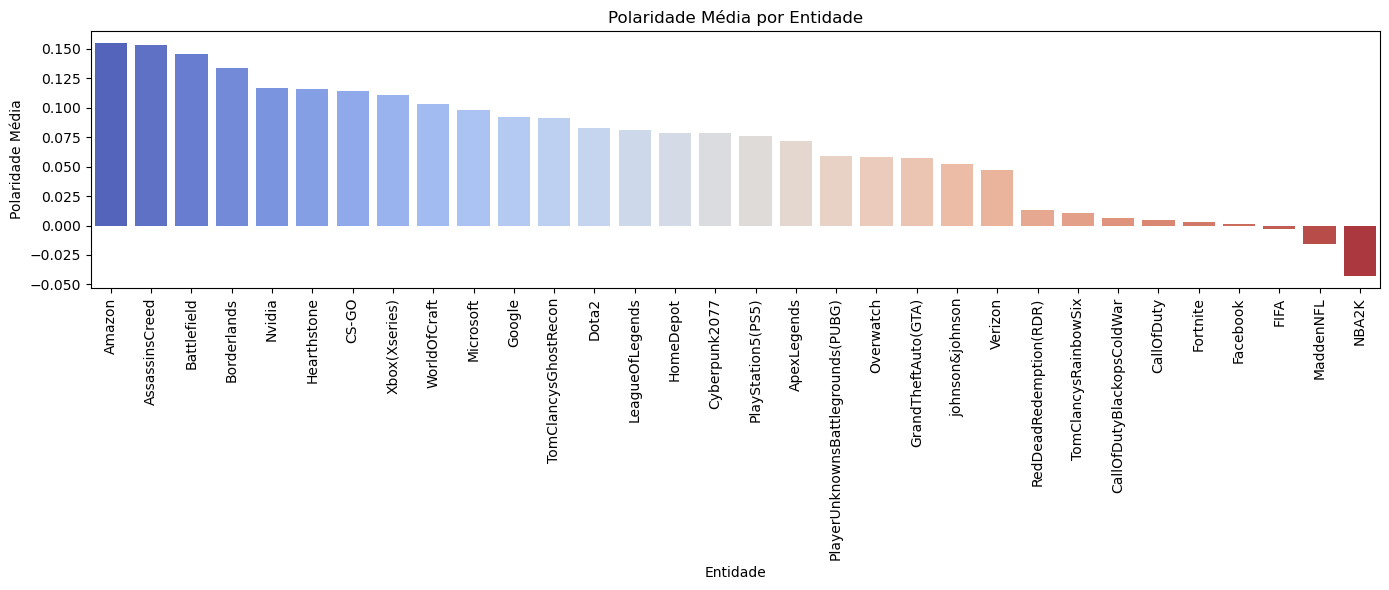

In [19]:
entity_sentiment = twitts_train.groupby('entity').agg({
    'polarity': ['mean', 'std', 'count'],
    'subjectivity': 'mean'
}).round(3)

entity_sentiment.columns = ['Polaridade_Média', 'Polaridade_Desvio', 'Quantidade', 'Subjetividade_Média']
entity_sentiment = entity_sentiment.sort_values('Polaridade_Média', ascending=False)


plt.figure(figsize=(14, 6))
sns.barplot(x=entity_sentiment.index, y=entity_sentiment['Polaridade_Média'], palette='coolwarm')
plt.title('Polaridade Média por Entidade')
plt.xlabel('Entidade')
plt.ylabel('Polaridade Média')
plt.xticks(ticks=np.arange(len(entity_sentiment.index)), labels=entity_sentiment.index, rotation=90, ha='center')
plt.tight_layout()
plt.show()

